<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, TimeSeriesSplit
from hyperopt import tpe, Trials, STATUS_OK, hp, fmin, space_eval
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from time import time
import datetime
import csv
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sample_submission = pd.read_csv("../preprocessed_data/sample_submission.csv")

In [3]:
with open('../preprocessed_data/data_type_key_test.json') as data_file:    
    data_types_train = json.load(data_file)

with open('../preprocessed_data/data_type_key_test.json') as data_file:
    data_types_test = json.load(data_file)
    
X_train = pd.read_csv("../preprocessed_data/X_train.csv", dtype=data_types_train)
y_train = pd.read_csv("../preprocessed_data/y_train.csv", header=None)
X_test = pd.read_csv("../preprocessed_data/X_test.csv", dtype=data_types_test)

In [4]:
best_params = {'bagging_fraction': 0.5062691484519468,
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.7987217136200802,
 'learning_rate': 0.014229099576591808,
 'max_depth': 17.0,
 'metric': 'auc',
 'min_child_samples': 210.0,
 'min_child_weight': 0.0008094702895930502,
 'num_leaves': 190.0,
 'objective': 'binary',
 'reg_alpha': 0.390432525090631,
 'reg_lambda': 0.06477877606229439,
 'tree_learner': 'serial',
 'verbosity': -1,
 'subsample': 0.9957814600262997}

In [5]:
def evaluate(params, X_train, y_train, X_test, NFOLDS=5):
    
    for parameter_name in ['num_leaves', 'min_child_samples', 'max_depth']:
        params[parameter_name] = int(params[parameter_name])
    
    y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    
    feature_importances = pd.DataFrame()
    feature_importances['features'] = X_train.columns
    
    training_start = time()
    
    print("New RUN")
    
    kfold = KFold(n_splits=NFOLDS, shuffle=False, random_state=1017)
    mean_score = 0
    
    for fold, (tr_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        start_time = time()
        
        trn_x, trn_y = X_train.iloc[tr_idx, :], y_train.iloc[tr_idx, :]
        val_x, val_y = X_train.iloc[val_idx, :], y_train.iloc[val_idx, :]
        
        trn_data = lgb.Dataset(trn_x, label=trn_y)
        val_data = lgb.Dataset(val_x, label=val_y)
        
        clf = lgb.train(params, trn_data, 10000, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=200)
        
        feature_importances[f"fold_{fold + 1}"] = clf.feature_importance()
        
        y_pred_valid = clf.predict(val_x)
        y_oof[val_idx] = y_pred_valid
        
        val_roc_auc = roc_auc_score(val_y, y_pred_valid)
        mean_score += val_roc_auc / NFOLDS
        y_preds += clf.predict(X_test) / NFOLDS
        
        fold_finish_time = datetime.timedelta(seconds=time() - start_time)
        print(f"Fold {fold + 1} auc_score: {val_roc_auc} and finished in {fold_finish_time}")
    
    total_time = time() - training_start
    print(f"Total tuning time: {round(total_time / 60, 2)}")
    gc.collect()
    del trn_x, trn_y, val_x, val_y
    print(f"Mean AUC score = {mean_score}")
    print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
    
    return feature_importances, y_preds

In [6]:
feature_imp_df, y_prediction = evaluate(best_params, X_train, y_train, X_test)

New RUN
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.983018	valid_1's auc: 0.916237
[1000]	training's auc: 0.992874	valid_1's auc: 0.917727
Early stopping, best iteration is:
[884]	training's auc: 0.991366	valid_1's auc: 0.91818
Fold 1 auc_score: 0.9181801497182215 and finished in 0:09:17.495365
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.984509	valid_1's auc: 0.935032
[1000]	training's auc: 0.994052	valid_1's auc: 0.938267
Early stopping, best iteration is:
[1158]	training's auc: 0.995481	valid_1's auc: 0.938503
Fold 2 auc_score: 0.9385026109607625 and finished in 0:12:15.306220
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.985224	valid_1's auc: 0.931636
[1000]	training's auc: 0.994503	valid_1's auc: 0.934174
Early stopping, best iteration is:
[1153]	training's auc: 0.995702	valid_1's auc: 0.934514
Fold 3 auc_score: 0.9345140011128816 and finished in 0:09:04.26

In [7]:
sample_submission['isFraud'] = y_prediction
sample_submission.to_csv("../submission/submission3.csv", index=False)

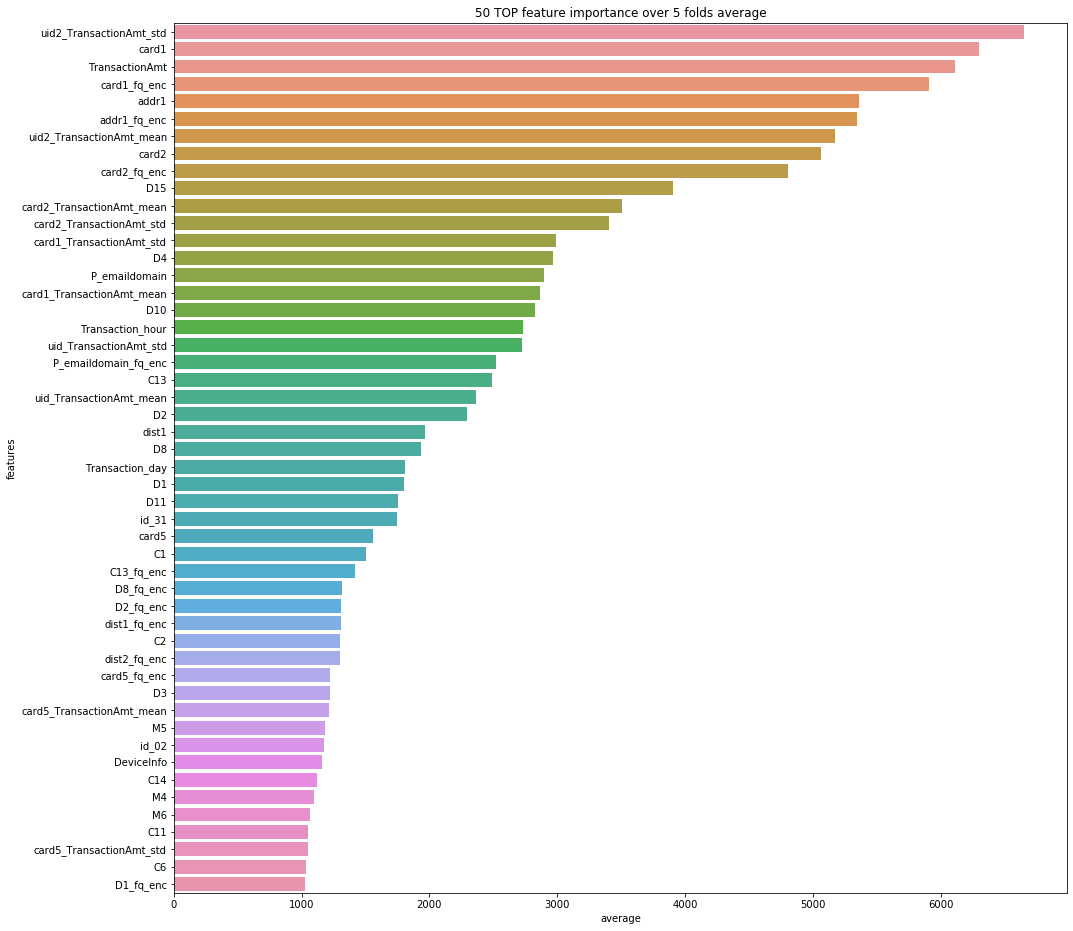

In [8]:
feature_imp_df['average'] = feature_imp_df[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)
feature_imp_df.to_csv('../submission/feature_importances1.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_imp_df.sort_values(by='average', ascending=False).head(50), x='average', y='features');
plt.title('50 TOP feature importance over {} folds average'.format(5));